In [ ]:

%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [1]:
import numpy as onp

from jax.config import config ; config.update('jax_enable_x64', True)
import jax.numpy as np
from jax import random
from jax import jit
from jax import lax

import time

from jax_md import space, smap, energy, minimize, quantity, simulate

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

Creating a dataset
- Pick number of particles, dimension, box size
- Set sigma, the parameter telling us the minimum energy distance between two particles
- Pick the species split (remember this, because it determines the species labels)

In [35]:
N = 100
dimension = 2
box_size = 10
displacement, shift = space.periodic(box_size) 
n_steps = 200
ts = 1e-2
n_lax_loop = 1
t = onp.arange(0, n_steps, n_lax_loop) * ts

In [30]:
key = random.PRNGKey(0)
R = random.uniform(key, (N, dimension), minval=0.0, maxval=box_size, dtype=np.float64)

# The system ought to be a 50:50 mixture of two types of particles, one
# large and one small.
sigma = np.array([[1.0, 1.2], [1.2, 1.4]])   # is the minimum locatione
N_2 = int(N / 2)
species = np.where(np.arange(N) < N_2, 0, 1)

In [31]:



energy_fn = energy.soft_sphere_pair(displacement, species=species, sigma=sigma)


init, apply = simulate.nve(energy_fn, shift, ts)
step = jit(lambda i, state: apply(state))
state = init(key, R, kT=0.0)

In [2]:
from jax import numpy as jnp
positions = jnp.array([[0.5, 0.5], [0.5, 0.5]])
species = jnp.arange(2)
sigma = np.array([[1.0, 1.2], [1.2, 1.4]])
energy_fn_test = energy.soft_sphere_pair(displacement, species=species, sigma=sigma)

plt.plot(t, PE, label='PE', linewidth=3)
plt.plot(t, KE, label='KE', linewidth=3)
plt.plot(t, PE + KE, label='Total Energy', linewidth=3)
plt.legend()
format_plot('t', '')
finalize_plot()

2022-05-01 20:12:14.335407: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


NameError: name 'plt' is not defined

DeviceArray([0], dtype=int32)

In [32]:
PE = []
KE = []

print_every = 20
old_time = time.time()
print('Step\tKE\tPE\tTotal Energy\ttime/step')
print('----------------------------------------')


data = {'R':[], 'F':[], 'z':[], 'V':[]}
for i in range(n_steps):
  state = lax.fori_loop(0, n_lax_loop, step, state)
  
  PE += [energy_fn(state.position)]
  KE += [quantity.kinetic_energy(state.velocity)]
  
  if i % print_every == 0 and i > 0:
    new_time = time.time()
    print('{}\t{:.2f}\t{:.2f}\t{:.3f}\t{:.2f}'.format(
        i * print_every, KE[-1], PE[-1], KE[-1] + PE[-1], 
        (new_time - old_time) / print_every / 10.0))
    old_time = new_time

  data['R'] += [np.array(state.position, dtype=np.float32)]
  data['F'] += [np.array(state.force, dtype=np.float32)]
  data['V'] += [np.array(state.velocity, dtype=np.float32)]
data['z'] = species + 1

PE = np.array(PE)
KE = np.array(KE)
R = state.position

data = {np.con}
np.savez('test_data.npz', **data)

Step	KE	PE	Total Energy	time/step
----------------------------------------
1	0.01	17.63	17.640	0.17
2	0.02	17.62	17.640	0.01
3	0.04	17.60	17.640	0.01
4	0.06	17.58	17.640	0.02
5	0.08	17.56	17.640	0.01
6	0.11	17.53	17.640	0.01
7	0.14	17.50	17.640	0.01
8	0.18	17.46	17.640	0.01
9	0.22	17.42	17.640	0.01
10	0.27	17.37	17.640	0.01
11	0.32	17.32	17.640	0.01
12	0.38	17.26	17.640	0.01
13	0.43	17.21	17.640	0.01
14	0.50	17.14	17.640	0.01
15	0.57	17.08	17.640	0.02
16	0.64	17.00	17.640	0.02
17	0.71	16.93	17.640	0.01
18	0.79	16.85	17.640	0.01
19	0.87	16.77	17.640	0.01
20	0.96	16.68	17.640	0.01
21	1.05	16.59	17.640	0.01
22	1.14	16.50	17.640	0.01
23	1.24	16.40	17.640	0.03
24	1.34	16.30	17.640	0.01
25	1.44	16.20	17.640	0.01
26	1.55	16.09	17.640	0.01
27	1.65	15.99	17.640	0.01
28	1.77	15.87	17.640	0.01
29	1.88	15.76	17.640	0.02
30	2.00	15.64	17.640	0.01
31	2.12	15.52	17.640	0.02
32	2.24	15.40	17.640	0.01
33	2.36	15.28	17.640	0.01
34	2.49	15.15	17.640	0.01
35	2.62	15.02	17.640	0.01
36	2.75	14.89	17.640	0.0

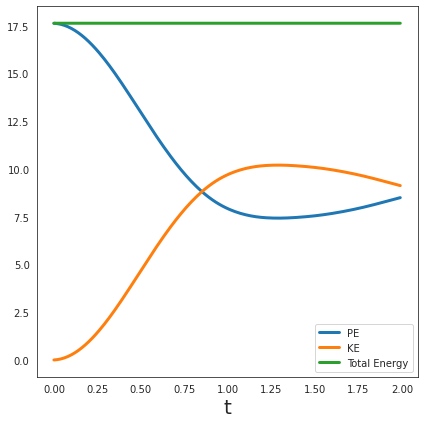

In [36]:

plt.plot(t, PE, label='PE', linewidth=3)
plt.plot(t, KE, label='KE', linewidth=3)
plt.plot(t, PE + KE, label='Total Energy', linewidth=3)
plt.legend()
format_plot('t', '')
finalize_plot()

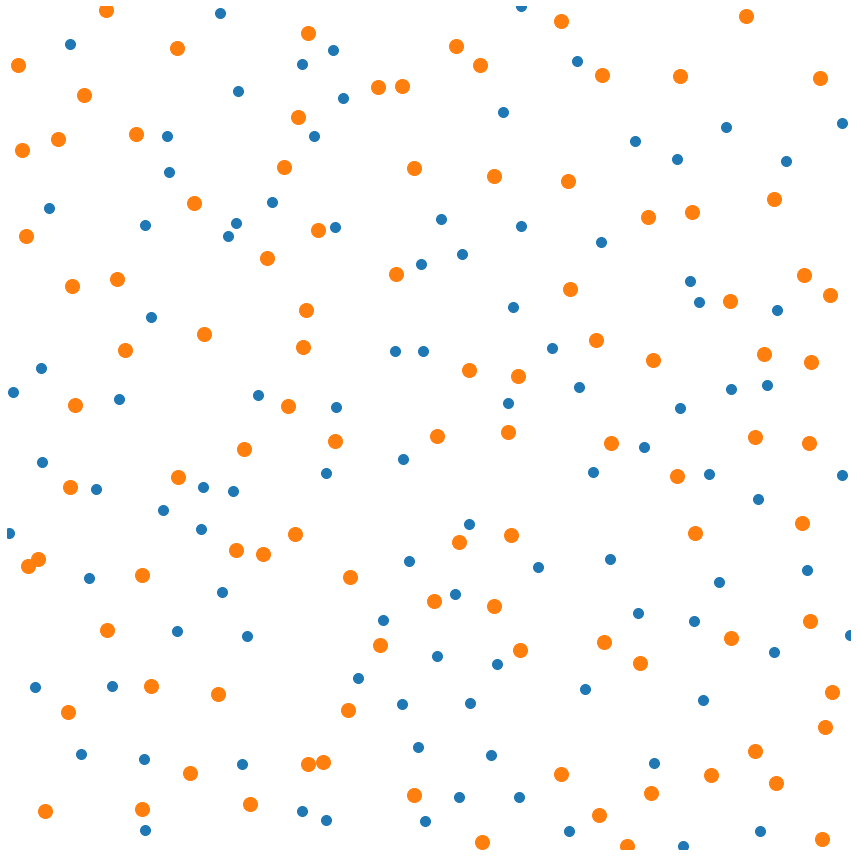

In [26]:
ms = 20
R_plt = onp.array(state.position)

plt.plot(R_plt[:N_2, 0], R_plt[:N_2, 1], 'o', markersize=ms * 0.5)
plt.plot(R_plt[N_2:, 0], R_plt[N_2:, 1], 'o', markersize=ms * 0.7)

plt.xlim([0, np.max(R[:, 0])])
plt.ylim([0, np.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))

In [27]:
state.position

state.velocity

print(dir(state))


['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'force', 'mass', 'position', 'velocity']


In [28]:
state.mass


DeviceArray(1., dtype=float32)

In [37]:
x = np.load('test_data.npz')
print(list(x.keys()))

['R', 'F', 'z', 'V']


(200, 100, 2)